### Figure 7: Stochasticity 

In [1]:
import numpy as np
from esda.moran import Moran,Moran_Local
from libpysal.weights import lat2W
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import properscoring as ps
import warnings
from scipy import stats
# from utils.evaluation import plot_histogram,calc_peak,calc_mean
from sklearn.metrics import mean_squared_error
from math import sqrt
import xesmf as xe
warnings.filterwarnings("ignore")
sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))

# https://journals.ametsoc.org/view/journals/atsc/72/6/jas-d-14-0250.1.xml
# https://www.sciencedirect.com/science/article/pii/S0021999107000812

/user/work/al18709/.conda/envs/aquatic/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
model = ''
# set mode
mode = 'validation'

# load datasets
real = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_real-opt.npy' % (model,mode))[0][:,:,:,0]
pred = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0][:,:,:,0]

pred_cnn = np.load('/user/home/al18709/work/cnn/unet_valid.npy')
pred_dsrnngan = np.load('/user/home/al18709/work/dsrnngan_predictions/validation_pred-opt.npy')[0][:,:,:,0]
pred_vaegan = np.load('/user/home/al18709/work/vaegan/predictions/validation_pred.npy')[0][:,:,:,0]

# pred_ensemble_vaegan = np.load('/user/home/al18709/work/vaegan/predictions/validation_pred.npy')[0]
# pred_ensemble_gan = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0]
pred_ensemble_vaegan = np.load('/user/home/al18709/work/vaegan_predictions_20/validation_pred-opt_improve.npy')
pred_ensemble_gan = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_improve.npy')
inputs = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_input-opt.npy' % (model,mode))[0][:,:,:,0]

# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
inputs_hr = regridder(inputs)

print(inputs_hr.shape)

(16253, 100, 100)


In [3]:
i=0
j=0
_,_,_,n = pred_ensemble_gan.shape
var = np.var(pred_ensemble_gan[0,:,:,:],axis=2)
correction_var = n / (n - 1)
var = var * correction_var

print(pred_ensemble_gan.shape)
ens_mean = np.mean(pred_ensemble_gan[0,:,:,:],axis=2)
print(ens_mean.shape)
mse = np.square(ens_mean - real[0,:,:])
correction_mse = n / (n + 1)
mse = mse * correction_mse

var_flat = var.flatten()
mse_flat = mse.flatten()

# put into 20 bins of 5% percentiles of the spread
mean_vars = []
mean_mses = []
for i,p in enumerate(range(5,100,5)):

	# find the indexes of the element below 25th and 50th percentile
	idx_under_p1 = np.argwhere(var_flat <= np.percentile(var_flat, p)).ravel()
	idx_under_p2 = np.argwhere(var_flat <= np.percentile(var_flat, range(5,105,5)[i+1])).ravel()

	# find the number of the elements in between 25th and 50th percentile
	diff_num = np.abs(len(idx_under_p1) - len(idx_under_p2))

	# find the sum difference
	diff_sum_var = np.abs(np.sum(np.take(var_flat, idx_under_p2)) - np.sum(np.take(var_flat, idx_under_p1)))
	diff_sum_mse = np.abs(np.sum(np.take(mse_flat, idx_under_p2)) - np.sum(np.take(mse_flat, idx_under_p1)))

	# get the mean
	mean_mse = diff_sum_mse / diff_num
	mean_var = diff_sum_var / diff_num

	mean_vars.append(mean_var)
	mean_mses.append(mean_mse)

print(mean_vars)
print(mean_mses)

rmse = np.sqrt(mean_mses)
rmss = np.sqrt(mean_vars)

print(rmse)
print(rmss)

# TODO: why is this negative!?

(16253, 100, 100, 20)
(100, 100)
[0.0004778796401941698, 0.000825919878432624, 0.0012948657912576248, 0.00191285180174859, 0.0028100012944706617, 0.00409411109370162, 0.005842537604297805, 0.00923763274018484, 0.014662603416861682, 0.022909495911135287, 0.03626920009638256, 0.05951470927638442, 0.09813373273392824, 0.1654956713973075, 0.3105513402432031, 0.6556471686021933, 1.6640452814827278, 4.6839244432396665, 17.968463390920085]
[0.004027960319584239, 0.007661420174087177, 0.014757576156971108, 0.018441718628123268, 0.021235305567255273, 0.0204898487911059, 0.052502570332180684, 0.04050073451836238, 0.1027934137622487, 0.24349191760504557, 0.38919345861788224, 0.4612663231344486, 0.6479781570816509, 1.2289292577903403, 1.9371101773274664, 2.986428614369998, 5.399261346514527, 7.009083320205054, 16.362683401155465]
[0.06346621 0.08752954 0.12148076 0.13580029 0.14572339 0.14314276
 0.22913439 0.20124794 0.32061412 0.493449   0.62385372 0.6791659
 0.8049709  1.10857082 1.39180106 1.7

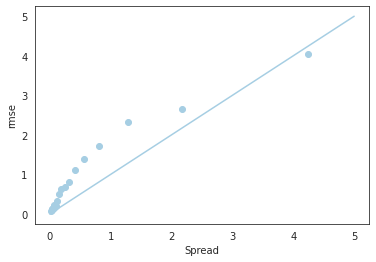

In [4]:
plt.scatter(rmss,rmse)
plt.xlabel('Spread')
plt.ylabel('rmse')
plt.xticks([0,1,2,3,4,5])
plt.yticks([0,1,2,3,4,5])
plt.plot([0,1,2,3,4,5],[0,1,2,3,4,5])
plt.show()

In [5]:
def spread_error(pred_ensemble):
	_,_,_,n = pred_ensemble.shape
	var = np.var(pred_ensemble[:,:,:,:],axis=3)
	correction_var = n / (n - 1)
	var = var * correction_var

	print(pred_ensemble.shape)
	ens_mean = np.mean(pred_ensemble[:,:,:,:],axis=3)
	print(ens_mean.shape)
	mse = np.square(ens_mean - real[:,:,:])
	correction_mse = n / (n + 1)
	mse = mse * correction_mse

	var_flat = var.flatten()
	mse_flat = mse.flatten()

	# put into 20 bins of 5% percentiles of the spread
	mean_vars = []
	mean_mses = []
	for i,p in enumerate(range(5,100,5)):

		# find the indexes of the element below 25th and 50th percentile
		idx_under_p1 = np.argwhere(var_flat <= np.percentile(var_flat, p)).ravel()
		idx_under_p2 = np.argwhere(var_flat <= np.percentile(var_flat, range(5,105,5)[i+1])).ravel()

		# find the number of the elements in between 25th and 50th percentile
		diff_num = np.abs(len(idx_under_p1) - len(idx_under_p2))

		# find the sum difference
		diff_sum_var = np.abs(np.sum(np.take(var_flat, idx_under_p2)) - np.sum(np.take(var_flat, idx_under_p1)))
		diff_sum_mse = np.abs(np.sum(np.take(mse_flat, idx_under_p2)) - np.sum(np.take(mse_flat, idx_under_p1)))

		# get the mean
		mean_mse = diff_sum_mse / diff_num
		mean_var = diff_sum_var / diff_num

		mean_vars.append(mean_var)
		mean_mses.append(mean_mse)

	rmse = np.sqrt(mean_mses)
	rmss = np.sqrt(mean_vars)

	return rmse,rmss



(16253, 100, 100, 20)
(16253, 100, 100)


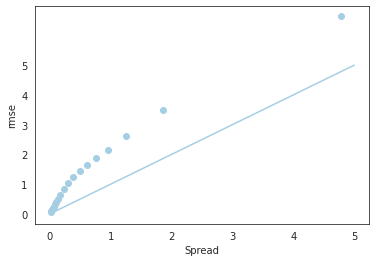

(16253, 100, 100, 20)
(16253, 100, 100)


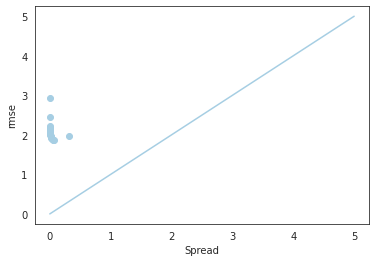

In [6]:
rmse,rmss = spread_error(pred_ensemble_gan)

plt.scatter(rmss,rmse)
plt.xlabel('Spread')
plt.ylabel('rmse')
plt.xticks([0,1,2,3,4,5])
plt.yticks([0,1,2,3,4,5])
plt.plot([0,1,2,3,4,5],[0,1,2,3,4,5])
plt.show()

rmse,rmss = spread_error(pred_ensemble_vaegan)

plt.scatter(rmss,rmse)
plt.xlabel('Spread')
plt.ylabel('rmse')
plt.xticks([0,1,2,3,4,5])
plt.yticks([0,1,2,3,4,5])
plt.plot([0,1,2,3,4,5],[0,1,2,3,4,5])
plt.show()

In [8]:
print(pred_ensemble_vaegan.shape)
pred_ensemble_vaegan = np.load('/user/home/al18709/work/vaegan_predictions_20/validation_pred-opt_improve.npy')
pred_ensemble_gan = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_improve.npy')
print(pred_ensemble_vaegan.shape)

(16253, 100, 100, 20)
(16253, 100, 100, 20)


In [9]:
def spread_error2(ensemble,real):
	_,_,_,n = ensemble.shape
	var = np.var(ensemble,axis=3)
	# correction_var = n / (n - 1)
	# var = var * correction_var

	ens_mean = np.mean(ensemble,axis=3)
	error = np.square(ens_mean - real)
	spread = np.std(ensemble,axis=3)

	# correction_mse = n / (n + 1)
	# mse = mse * correction_mse

	spread_flat = spread.flatten()
	error_flat = error.flatten()
	# print(spread_flat.shape)
	# print(error_flat.shape)

	# put into 20 bins of 5% percentiles of the spread
	mean_spreads = []
	mean_errors = []
	for i,p in enumerate(range(5,100,5)):

		# find the indexes of the element below 25th and 50th percentile
		idx_under_p1 = np.argwhere(spread_flat <= np.percentile(spread_flat, p)).ravel()
		idx_under_p2 = np.argwhere(spread_flat <= np.percentile(spread_flat, range(5,105,5)[i+1])).ravel()
		idx_under_p1_ = np.argwhere(error_flat <= np.percentile(error_flat, p)).ravel()
		idx_under_p2_ = np.argwhere(error_flat <= np.percentile(error_flat, range(5,105,5)[i+1])).ravel()

		# find the number of the elements in between 25th and 50th percentile
		diff_num = np.abs(len(idx_under_p1) - len(idx_under_p2))

		# find the sum difference
		diff_sum_spread = np.abs(np.sum(np.take(spread_flat, idx_under_p2)) - np.sum(np.take(spread_flat, idx_under_p1)))
		diff_sum_error = np.abs(np.sum(np.take(error_flat, idx_under_p2_)) - np.sum(np.take(error_flat, idx_under_p1_)))

		# get the mean
		mean_error = diff_sum_error / diff_num
		mean_spread = diff_sum_spread / diff_num

		mean_errors.append(mean_error)
		mean_spreads.append(mean_spread)
	# print(mean_errors.shape)
	# print(mean_spread.shape)
	error = np.sqrt(mean_errors)
	spread = np.sqrt(mean_spread)

	return spread,error


In [10]:
spread,error = spread_error2(pred_ensemble_vaegan,real)
print(spread.shape)
print(error.shape)

KeyboardInterrupt: 

In [20]:

def spread_error3(ensemble,real):
	_,_,_,n = ensemble.shape
	var = np.var(ensemble,axis=3)

	ens_mean = np.mean(ensemble,axis=3)
	error = np.square(ens_mean - real)
	# var = np.square(var)
	# errors = []
	# for e in range(n):
	# 	error = np.abs(ensemble[:,:,:,e] - real)
	# 	squared_error = error * error
	# 	mse = np.mean(np.mean(squared_error,axis=1),axis=1)
	# 	rmse = np.sqrt(mse)
	# 	errors.append(rmse)
	# spread = np.std(ensemble,axis=3)
	return var,error

spread,error = spread_error3(pred_ensemble_vaegan,real)
# print(spread.shape)
# print(np.array(error).shape)
# error = np.sort(np.mean(error,axis=0))
spread = np.sort(np.mean(np.mean(spread,axis=1),axis=1))
# spread = np.sqrt(spread)
error = np.sort(np.mean(np.mean(error,axis=1),axis=1))
error = np.sqrt(error)


In [21]:
print(spread.shape)
print(error.shape)

(16253,)
(16253,)


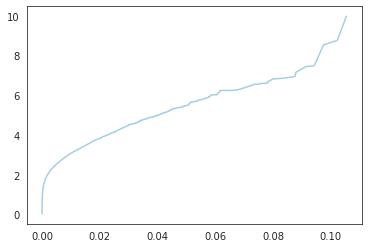

In [22]:
plt.plot(spread,error)
plt.show()

In [ ]:
# https://www.jstor.org/stable/24914540?seq=2#metadata_info_tab_contents